# Experiment 1
## Comparing Multiple Lemmatizations
Name: Xin Wei Lam<br>
Username: xl00751<br>
URN: 6525195

In this experiment, I have successfully used NLTK and spaCy lemmatizers. I had attempted to use Gensim, TreeTaggerWrapper and TextBlob as well but ran into various issues.

Gensim's lemmatizer relied on Pattern, but Pattern has not been updated for several years, so Gensim has removed their lemmatize function from Gensnim 4.0. The discussion can be found here: https://github.com/RaRe-Technologies/gensim/issues/2716

TreeTaggerWrapper required multiple local installations to use compared to a simple pip install command which other libraries use. First their package, then their tagging scripts, followed by installation scripts and finally parameter files. I was concerned that due to a multi-step installation, it would not work properly when run on a different computer. (https://www.cis.lmu.de/~schmid/tools/TreeTagger/)

Lastly, TextBlob made use of TextBlob and Word objects. TextBlob only takes in non-tokenized Strings and Word only takes in a single word String. To use TextBlob, I would have to use untokenized text which would not make for a fair experiment as NLTK and spaCy performed lemmatizations on sentences tokenized by the same library (NLTK). While documentation states that they have WordList objects which contains Words in a TextBlob, WordLists do not have contain a pos tags parameter which makes me unable to use it for lemmatization. 

In [1]:
import keras
import numpy as np
import pandas as pd
import pickle
import sklearn
import tensorflow as tf

In [20]:
# File paths

# Data Directory
DATA_DIR = "data"

# Balanced datasets
BALANCED_TRAIN_DATASET = "data/balanced_dataset.pickle"
BALANCED_TEST_DATASET = "data/balanced_test_dataset.pickle"

# Preprocessed balanced data
PREPROCESSED_BAL_TRAIN_DATASET = "data/preprocessed_train.pickle"
PREPROCESSED_BAL_TEST_DATASET = "data/preprocessed_test.pickle"

In [3]:
# Function to save data as a .pickle file
# Params: 
    # List or Dataframe - @data: Data to be saved as pickle
    # Str - @folder: folder name
    # Str - file name
# Output: Pickle file in directory/repo 
def save_pickle(data, folder, file_name):
    with open("{0}/{1}.pickle".format(folder, file_name), 'wb') as f:
        pickle.dump(data, f)
    print(f"Saved data is stored in \'{folder}\' in the form of {file_name}.pickle")
    #pickle.dump(data, open("data/{0}.pickle".format(file_name),"wb"))

# Function to load pickle file
# Params:
    # Str - @file_path: File path of pickle file
# Output:
    # Saved object in original file type (list/dataframe)
def load_pickle(file_path):
    return pickle.load(open(file_path, "rb"))

In [21]:
# Load datasets

# Balanced, unprocessed datasets
bal_train_df = load_pickle(BALANCED_TRAIN_DATASET)
bal_test_df = load_pickle(BALANCED_TEST_DATASET)

# Get preprocessed train dataset
bal_train_dataset = load_pickle(PREPROCESSED_BAL_TRAIN_DATASET)

# Get preprocessed test dataset
bal_test_dataset = load_pickle(PREPROCESSED_BAL_TEST_DATASET)

# Get train_y
bal_train_y = pd.read_pickle(BALANCED_TRAIN_DATASET)
bal_train_y = bal_train_y.drop(columns="comment_text")

# Get test_y
bal_test_y = pd.read_pickle(BALANCED_TEST_DATASET)
bal_test_y = bal_test_y.drop(columns="comment_text")

In [9]:
# Pre-processing imports
import functools
import nltk

from functools import lru_cache
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [10]:
# Pre-processing functions

# Function to clean comments in train dataset
# Params: 
#   pd dataframe    - @train_dataset: Training dataset
# Output: 
#   2D List         - @comment_list: cleaned comments
def clean_data(train_dataset):
    # Remove punctuation
    regex_str = "[^a-zA-Z\s]"
    train_dataset['comment_text'] = train_dataset['comment_text'].replace(regex=regex_str, value="")

    # Remove extra whitespaces
    regex_space = "\s+"
    train_dataset['comment_text'] = train_dataset['comment_text'].replace(regex=regex_space, value=" ")

    # Strip whitespaces
    train_dataset['comment_text'] = train_dataset['comment_text'].str.strip()

    # Lowercase
    train_dataset['comment_text'] = train_dataset['comment_text'].str.lower()

    # Convert comment_text column into a list
    comment_list = train_dataset['comment_text'].tolist()

    return comment_list

# Function to get NLTK POS Tagger
# Params: 
#   Str - @word: Token
# Output
#   Dict - POS tagger
def nltk_get_wordnet_pos(word):
    
    tag = nltk.pos_tag([word])[0][1][0].upper()

    # Convert NLTK to wordnet POS notations

    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN) # Default to noun if not found

# Function to use NLTK lemmatizer
# Params: 2D List - Tokenized comments with stopwords removed
# Returns: 2D List - lemmatized tokens
def nltk_lemmatize(comment_stop):

    nltk.download('averaged_perceptron_tagger')
    comment_lemma = []
    lemmatizer = WordNetLemmatizer()
    lemmatizer_cache = lru_cache(maxsize=50000)(lemmatizer.lemmatize)

    for comment in comment_stop:
        temp = []
        temp.append([lemmatizer_cache(word, pos=nltk_get_wordnet_pos(word)) for word in comment])
        comment_lemma += temp

    return comment_lemma

# Function to remove NLTK stopwords
# Params: 
#   2D List - @comment_token: cleaned & tokenized comments
# Output:
#   2D List - @comment_stop: cleaned tokens with stopwords removed
def nltk_stopwords(comment_token):
    # Stopwords in English only
    STOP_WORDS = set(stopwords.words('english'))

    # Remove stopwords
    comment_stop = []

    for comment in comment_token:
        
        temp_word = []

        for word in comment:
            
            if word not in STOP_WORDS:
                temp_word.append(word)

        comment_stop.append(temp_word)
    
    return comment_stop

# Function to tokenize comments using NLTK Word Tokenize
# Params: 
#   2D List - @text: cleaned comments
# Output: 
#   2D List - tokenized comments
def nltk_tokenize(text):
    return [word_tokenize(word) for word in text]

# Function for all pre-processing functions
# Params:
    # Pandas Dataframe  - @dataset: Dataset to be pre-processed (train/test)
    # Str               - @file_name: File name to save pre-processed data as pickle
# Output: Pickle file in directory/repo
def preprocess_data(dataset, file_name):

    comment_cleaned = clean_data(dataset)
    
    # NLTK Tokenize
    comment_token = nltk_tokenize(comment_cleaned)

    # Remove NLTK stopwords
    comment_stop = nltk_stopwords(comment_token)

    # NLTK Lemmatization
    comment_lemma = nltk_lemmatize(comment_stop)

    save_pickle(comment_lemma, folder, file_name)

In [11]:
# Prepare basic pre-processing steps until before lemmatization

# Train dataset
train_clean = clean_data(bal_train_df)
train_token = nltk_tokenize(train_clean)
train_stopwords = nltk_stopwords(train_token)

# Test dataset
test_clean = clean_data(bal_test_df)
test_token = nltk_tokenize(test_clean)
test_stopwords = nltk_stopwords(test_clean)

# NLTK Lemmatization
The tokens have already been lemmatized by NLTK in basic pre-processing, but since it is a method of lemmatization, I am including it in the experiment.

NLTK requires each token to be tagged to a pos tag. NLTK uses WordNetLemmatizer, so it gets pos tags from WordNet. We are required to create a dictionary to convert NLTK's own pos tags to WordNet's equivalent.

In [8]:
# Function to get NLTK POS Tagger
# Params: 
#   Str - @word: Token
# Output
#   Dict - POS tagger
def nltk_get_wordnet_pos(word):
    
    tag = nltk.pos_tag([word])[0][1][0].upper()

    # Convert NLTK to wordnet POS notations
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN) # Default to noun if not found

# Function to use NLTK lemmatizer
# Params: 2D List - Tokenized comments with stopwords removed
# Returns: 2D List - lemmatized tokens
def nltk_lemmatize(comment_stop):

    nltk.download('averaged_perceptron_tagger')
    comment_lemma = []
    lemmatizer = WordNetLemmatizer()
    lemmatizer_cache = lru_cache(maxsize=50000)(lemmatizer.lemmatize)

    for comment in comment_stop:
        temp = []
        temp.append([lemmatizer_cache(word, pos=nltk_get_wordnet_pos(word)) for word in comment])
        comment_lemma += temp

    return comment_lemma

In [9]:
# Get comments lemmatized with NLTK to compare
comments_nltk = nltk_lemmatize(train_stopwords)
print(comments_nltk[:2])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lamxw\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[['cocksucker', 'piss', 'around', 'work'], ['gay', 'antisemmitian', 'archangel', 'white', 'tiger', 'meow', 'greetingshhh', 'uh', 'two', 'way', 'erase', 'comment', 'ww', 'holocaust', 'brutally', 'slay', 'jew', 'gaysgypsysslavsanyone', 'antisemitian', 'shave', 'head', 'bald', 'go', 'skinhead', 'meeting', 'doubt', 'word', 'bible', 'homosexuality', 'deadly', 'sin', 'make', 'pentagram', 'tatoo', 'forehead', 'go', 'satanistic', 'mass', 'gay', 'pal', 'first', 'last', 'warn', 'fuck', 'gay', 'wont', 'appreciate', 'nazi', 'shwain', 'would', 'write', 'page', 'dont', 'wish', 'talk', 'anymore', 'beware', 'dark', 'side']]


In [22]:
# Load from pickle for evaluation
comments_nltk = bal_train_dataset

# Spacy Lemmatization

In [5]:
import spacy
from spacy.tokens import Doc

In [6]:
# Load small version of spacy's language model
nlp = spacy.load("en_core_web_sm", disable=["textcat"], exclude=["parser", "ner"])

Since spacy tokenizes sentences automatically with their model, I have to replace their tokenizer with our used tokenizer (nltk) to ensure spacy's tokenizing function does not affect our result. I will need to modify nltk_tokenize() to return a spacy Doc object.

In [7]:
# Create each tokenized comment as a spacy Doc object, then add it to a list
# Params:
#   2D List - @comment_token: Tokenized comments with stopwords removed
# Output:
#   List    - @doc_list: List of Doc objects
def create_docs(comment_stopwords):

    doc_list = []

    for comment in comment_stopwords:

        single_comment = []

        for word in comment:
            single_comment.append(word)

        doc_list.append(Doc(nlp.vocab, single_comment))
        single_comment.clear()
    
    return doc_list

In [12]:
# Create list of Docs
doc_list = create_docs(train_stopwords)
print(len(doc_list))

7132


spaCy lemmatization has a known bug for a specific word 'first' and returns it as a unicode character. I am unsure if any other words are affected by a similar bug.

Reference: https://github.com/explosion/spaCy/issues/6281

I have chosen to workaround it by hardcoding it to 'first'. More details at the end of the notebook.

In [15]:
# Perform lemmatization with spaCy
# Params:
#   List    - @doc_list: List of Doc objects
# Output:
#   2D List - @comment_list: List of lemmatized tokens
def spacy_lemmatize(doc_list):

    comment_list = []

    for doc in doc_list:

        token_list = []

        for token in doc:

            lemma = token.lemma_

            # Hardcode '1' to 'first' to workaround spaCy bug
            if ord(lemma[0]) > 127:
                lemma = 'first'
                token_list.append(lemma)

            # spaCy lemmatization returns pronouns as '-PRON-', so exclude it
            elif lemma != '-PRON-':
                token_list.append(lemma)
        
        comment_list.append(token_list)
    
    return comment_list

I have attempted to resolve it by encoding/decoding it but it always resulted in '\ufeff1' despite printing '1' during my attempts. I have shown evidence of attempting it with 'convert_tokens()'. The following cell shows my attempt.

In [13]:
# Perform lemmatization with spaCy
# Params:
#   List    - @doc_list: List of Doc objects
# Output:
#   2D List - @comment_list: List of lemmatized tokens
def spacy_lemmatize_test(doc_list):

    comment_list = []

    for doc in doc_list:

        token_list = []

        #token_list.append([token.lemma_ for token in doc if token.lemma != '-PRON'])

        for token in doc:

            lemma = token.lemma_

            # spaCy lemmatization returns pronouns as '-PRON-', so exclude it
            if lemma != '-PRON-':
                token_list.append(lemma)
        
        comment_list.append(token_list)
    
    return comment_list

# Encode and decode unicode bug
# Does not work
# Params:
#   List    - @spacy_list: List of spaCy lemmatized tokens
# Output:
#   2D List - @comment_list: List of decoded tokens as required
def convert_tokens(spacy_list):

    comment_list = []

    for doc in spacy_list:

        token_list = []

        for token in doc:
            
            # If unicode
            if ord(token[0]) > 127:

                token = token.encode('utf-8')
                token = token.decode('utf-8')
                token_list.append(token)
            
            else:
                token_list.append(token)
        
        comment_list.append(token_list)
    
    return comment_list

comments_spacy_test = spacy_lemmatize_test(doc_list)
print(comments_spacy_test[:2])

# Result remains the same
comments_spacy_test = convert_tokens(comments_spacy_test)
print(comments_spacy_test[:2])

[['cocksucker', 'piss', 'around', 'work'], ['gay', 'antisemmitian', 'archangel', 'white', 'tiger', 'meow', 'greetingshhh', 'uh', 'two', 'way', 'erase', 'comment', 'ww', 'holocaust', 'brutally', 'slay', 'jews', 'gaysgypsysslavsanyone', 'antisemitian', 'shave', 'head', 'bald', 'go', 'skinhead', 'meeting', 'doubt', 'word', 'bible', 'homosexuality', 'deadly', 'sin', 'make', 'pentagram', 'tatoo', 'forehead', 'go', 'satanistic', 'masse', 'gay', 'pal', '\ufeff1', 'last', 'warn', 'fuck', 'gay', 'wont', 'appreciate', 'nazi', 'shwain', 'would', 'write', 'page', 'do', 'wish', 'talk', 'anymore', 'beware', 'dark', 'side']]
[['cocksucker', 'piss', 'around', 'work'], ['gay', 'antisemmitian', 'archangel', 'white', 'tiger', 'meow', 'greetingshhh', 'uh', 'two', 'way', 'erase', 'comment', 'ww', 'holocaust', 'brutally', 'slay', 'jews', 'gaysgypsysslavsanyone', 'antisemitian', 'shave', 'head', 'bald', 'go', 'skinhead', 'meeting', 'doubt', 'word', 'bible', 'homosexuality', 'deadly', 'sin', 'make', 'pentagra

In [16]:
comments_spacy = spacy_lemmatize(doc_list)
print(comments_spacy[:2])

[['cocksucker', 'piss', 'around', 'work'], ['gay', 'antisemmitian', 'archangel', 'white', 'tiger', 'meow', 'greetingshhh', 'uh', 'two', 'way', 'erase', 'comment', 'ww', 'holocaust', 'brutally', 'slay', 'jews', 'gaysgypsysslavsanyone', 'antisemitian', 'shave', 'head', 'bald', 'go', 'skinhead', 'meeting', 'doubt', 'word', 'bible', 'homosexuality', 'deadly', 'sin', 'make', 'pentagram', 'tatoo', 'forehead', 'go', 'satanistic', 'masse', 'gay', 'pal', 'first', 'last', 'warn', 'fuck', 'gay', 'wont', 'appreciate', 'nazi', 'shwain', 'would', 'write', 'page', 'do', 'wish', 'talk', 'anymore', 'beware', 'dark', 'side']]


## Fitting to Keras model

In [17]:
# Imports
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
# Constants for keras model
NUM_WORDS = 20000
MAX_LEN = 100

In [20]:
# Basic model
def build_model(num_words):
    EPOCHS = 30
    INIT_LR = 1e-3

    model = Sequential()

    model.add(Embedding(num_words, 128))
    model.add(Dropout(0.4))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))

    adam = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

    model.compile(loss='binary_crossentropy',
                optimizer=adam,
                metrics=['accuracy'])

    return model

# Model for NLTK

In [24]:
# Use Tensorflow's Tokenizer for text featurization
tokenizer = Tokenizer(NUM_WORDS)

# Update internal vocabulary
tokenizer.fit_on_texts(comments_nltk)

print(len(tokenizer.word_index))

23456


In [25]:
# Turn each word into its corresponding integer
nltk_train_x = tokenizer.texts_to_sequences(comments_nltk)

# Pad sequences
nltk_train_x = keras.preprocessing.sequence.pad_sequences(nltk_train_x, MAX_LEN)
nltk_train_x = np.array(nltk_train_x)

In [23]:
model = build_model(NUM_WORDS)

model.fit(nltk_train_x, bal_train_y, batch_size=60, epochs=30)

# Save model to use for evaluation
model.save('models/exp1_nltk')

Epoch 1/30
119/119 [==============================] - 23s 69ms/step - loss: 0.5687 - accuracy: 0.2899
Epoch 2/30
119/119 [==============================] - 7s 62ms/step - loss: 0.3669 - accuracy: 0.3531
Epoch 3/30
119/119 [==============================] - 7s 61ms/step - loss: 0.3015 - accuracy: 0.4100
Epoch 4/30
119/119 [==============================] - 8s 64ms/step - loss: 0.2715 - accuracy: 0.4221
Epoch 5/30
119/119 [==============================] - 8s 67ms/step - loss: 0.2565 - accuracy: 0.4261
Epoch 6/30
119/119 [==============================] - 9s 75ms/step - loss: 0.2419 - accuracy: 0.4461
Epoch 7/30
119/119 [==============================] - 10s 83ms/step - loss: 0.2318 - accuracy: 0.4708
Epoch 8/30
119/119 [==============================] - 10s 87ms/step - loss: 0.2150 - accuracy: 0.4744
Epoch 9/30
119/119 [==============================] - 10s 82ms/step - loss: 0.2049 - accuracy: 0.4776
Epoch 10/30
119/119 [==============================] - 10s 82ms/step - loss: 0.1844 - a

In [26]:
# Prepare test_x
# No preprocessing needs to be done on the dataset as the base model already made use of NLTK's lemmatization

# Turn each word into its corresponding integer
nltk_test_x = tokenizer.texts_to_sequences(bal_test_dataset)

# Pad sequences
nltk_test_x = keras.preprocessing.sequence.pad_sequences(nltk_test_x, MAX_LEN)
nltk_test_x = np.array(nltk_test_x)

print(nltk_test_x.shape)

(6978, 100)


# Model for spaCy

In [27]:
# Use Tensorflow's Tokenizer for text featurization
tokenizer = Tokenizer(NUM_WORDS)

# Update internal vocabulary
tokenizer.fit_on_texts(comments_spacy)

print(len(tokenizer.word_index))

23179


In [28]:
# Turn each word into its corresponding integer
spacy_train_x = tokenizer.texts_to_sequences(comments_spacy)

# Pad sequences
spacy_train_x = keras.preprocessing.sequence.pad_sequences(spacy_train_x, MAX_LEN)
spacy_train_x = np.array(spacy_train_x)

In [28]:
model = build_model(NUM_WORDS)

model.fit(spacy_train_x, bal_train_y, batch_size=60, epochs=30)

# Save model to use for evaluation
model.save('models/exp1_spacy')

Epoch 1/30
119/119 [==============================] - 9s 67ms/step - loss: 0.5661 - accuracy: 0.2872
Epoch 2/30
119/119 [==============================] - 7s 62ms/step - loss: 0.3640 - accuracy: 0.3744
Epoch 3/30
119/119 [==============================] - 8s 67ms/step - loss: 0.2984 - accuracy: 0.3947
Epoch 4/30
119/119 [==============================] - 8s 67ms/step - loss: 0.2733 - accuracy: 0.4226
Epoch 5/30
119/119 [==============================] - 8s 68ms/step - loss: 0.2608 - accuracy: 0.4582
Epoch 6/30
119/119 [==============================] - 8s 65ms/step - loss: 0.2435 - accuracy: 0.4669
Epoch 7/30
119/119 [==============================] - 8s 67ms/step - loss: 0.2338 - accuracy: 0.4693
Epoch 8/30
119/119 [==============================] - 7s 63ms/step - loss: 0.2190 - accuracy: 0.4799
Epoch 9/30
119/119 [==============================] - 8s 64ms/step - loss: 0.2014 - accuracy: 0.4682
Epoch 10/30
119/119 [==============================] - 8s 64ms/step - loss: 0.1955 - accura

In [29]:
# Prepare test_x

# Pre-process test_x 
spacy_clean = clean_data(bal_test_df)
spacy_tokens = nltk_tokenize(spacy_clean)
spacy_stopwords = nltk_stopwords(spacy_tokens)
spacy_docs = create_docs(spacy_stopwords)
spacy_test_x = spacy_lemmatize(spacy_docs)

# Turn each word into its corresponding integer
spacy_test_x = tokenizer.texts_to_sequences(spacy_test_x)

# Pad sequences
spacy_test_x = keras.preprocessing.sequence.pad_sequences(spacy_test_x, MAX_LEN)
spacy_test_x = np.array(spacy_test_x)

print(nltk_test_x.shape)

(6978, 100)


# Evaluation

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
from keras.metrics import Accuracy
from sklearn.metrics import classification_report, f1_score, multilabel_confusion_matrix, precision_score

In [31]:
# Number of labels for confusion matrix
NUM_CLASSES = 6

# Get accuracy with keras metrics Accuracy
# Params:
#   Numpy array - @y_pred: Obtained prediction
# Output:
#   Tensor      - Accuracy result
def get_accuracy(y_pred):

    acc = Accuracy()
    acc.update_state(y_true, y_pred)
    return acc.result().numpy()

# Get confusion matrix
# Params:
#   Numpy Array -       @y_pred:    Obtained prediction
# Output:
#   Numpy Array(Int) -  @cm_result: Confusion matrix
def get_confusion_matrix(y_pred):

    confusion_matrix = tfa.metrics.MultiLabelConfusionMatrix(num_classes=NUM_CLASSES)
    confusion_matrix.update_state(y_true, y_pred)

    cm_result = confusion_matrix.result()
    # Replace NaNs with 0, cast matrix as int
    cm_result = np.where(np.isnan(cm_result), 0, cm_result).astype(int)

    return cm_result

# Construct confusion matrix
# Params:
#   Confusion matrix    - @confusion_matrix:    Confusion matrix of trained model
#   Int                 - @axes:                Size of plot (row, col)
#   List                - @class_label:         Dataset labels
def show_confusion_matrix(confusion_matrix, axes, class_label, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=["N", "P"], columns=["N", "P"],
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

# Plot confusion matrix
# Params:
#   Numpy array(Int)    - @confusion_matrix: Confusion matrix
#   List                - @labels: List of labels
def plot_confusion_matrix(confusion_matrix, labels):

    fig, ax = plt.subplots(2, 3, figsize=(12, 7))
        
    for axes, cm, label in zip(ax.flatten(), confusion_matrix, labels):
        show_confusion_matrix(cm, axes, label)

    fig.tight_layout()
    plt.show()

In [32]:
# Load models

nltk_model = keras.models.load_model('models/exp1_nltk')
spacy_model = keras.models.load_model('models/exp1_spacy')

In [33]:
# Get labels
labels = list(bal_train_y.columns)

# Get y_true
y_true = bal_test_y

# Confusion matrix list by lemmatization
cm_list_by_lemma = []

# Get micro-average Precision score of each lemmatization
micro_precision_score = {}

# Get micro-average f1-score of each lemmatization
micro_f1 = {}

# Accuracy for each classifier
acc_dict = {}

## Compare the Output of NLTK lemmatization with spaCy's lemmatization

In [68]:
import tabulate
from tabulate import tabulate

In [64]:
compare_df = pd.DataFrame(train_stopwords[1], columns=['original'])
compare_df['nltk'] = pd.Series(comments_nltk[1], index=compare_df.index)
compare_df['spacy'] = pd.Series(comments_spacy[1], index=compare_df.index)
compare_df['same_result'] = np.where((compare_df['nltk'] == compare_df['spacy']), True, False)

In [69]:
print(tabulate(compare_df, headers='keys', tablefmt='simple'))

    original               nltk                   spacy                  same_result
--  ---------------------  ---------------------  ---------------------  -------------
 0  gay                    gay                    gay                    True
 1  antisemmitian          antisemmitian          antisemmitian          True
 2  archangel              archangel              archangel              True
 3  white                  white                  white                  True
 4  tiger                  tiger                  tiger                  True
 5  meow                   meow                   meow                   True
 6  greetingshhh           greetingshhh           greetingshhh           True
 7  uh                     uh                     uh                     True
 8  two                    two                    two                    True
 9  ways                   way                    way                    True
10  erased                 erase                

In [71]:
different_words_df = compare_df[compare_df['same_result']==False]
print(different_words_df)

   original  nltk  spacy  same_result
16     jews   jew   jews        False
37   masses  mass  masse        False
52     dont  dont     do        False


The difference is slight, but at a glance, NLTK appears to be the better lemmatizer as it has lemmatized 2/3 of the original words to its base form, while spaCy did not.

In [75]:
flatten_nltk = [word for comment in comments_nltk for word in comment]
flatten_spacy = [word for comment in comments_spacy for word in comment]

compare_df = pd.DataFrame(flatten_nltk, columns=['nltk'])
compare_df['spacy'] = pd.Series(flatten_spacy, index=compare_df.index)
compare_df['same_result'] = np.where((compare_df['nltk'] == compare_df['spacy']), True, False)

print(len(compare_df[compare_df['same_result']==False]))

15411


NLTK and spaCy lemmatized 15411 words differently.

# NLTK Lemmatization

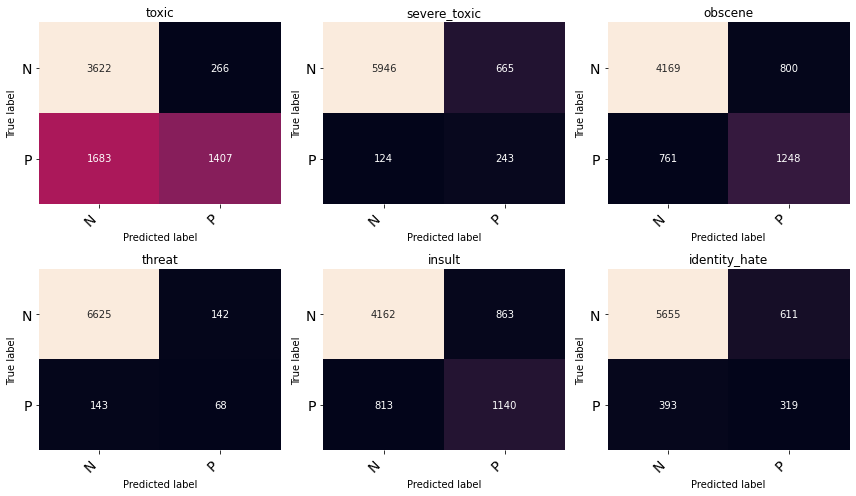

In [34]:
# Predictions
y_pred = nltk_model.predict(nltk_test_x)
y_pred_nltk = (y_pred > 0.5).astype("int32")

# Get confusion matrix
nltk_confusion_matrix = get_confusion_matrix(y_pred_nltk)

# Plot confusion matrix
plot_confusion_matrix(nltk_confusion_matrix, labels)

In [37]:
print(classification_report(y_true, y_pred_nltk, target_names=labels))

               precision    recall  f1-score   support

        toxic       0.84      0.46      0.59      3090
 severe_toxic       0.27      0.66      0.38       367
      obscene       0.61      0.62      0.62      2009
       threat       0.32      0.32      0.32       211
       insult       0.57      0.58      0.58      1953
identity_hate       0.34      0.45      0.39       712

    micro avg       0.57      0.53      0.55      8342
    macro avg       0.49      0.52      0.48      8342
 weighted avg       0.64      0.53      0.56      8342
  samples avg       0.19      0.21      0.19      8342

C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklear

In [38]:
# Get accuracy
acc_dict['nltk'] = get_accuracy(y_pred_nltk)
# Get micro-F1
micro_f1['nltk'] = f1_score(y_true, y_pred_nltk, average='micro')
# Get micro-precision
micro_precision_score['nltk'] = precision_score(y_true, y_pred_nltk, average='micro')

# Get sum of confusion matrices by lemmatization
cm_sum = sum(nltk_confusion_matrix)
cm_list_by_lemma.append(cm_sum.flatten())

# spaCy Lemmatization

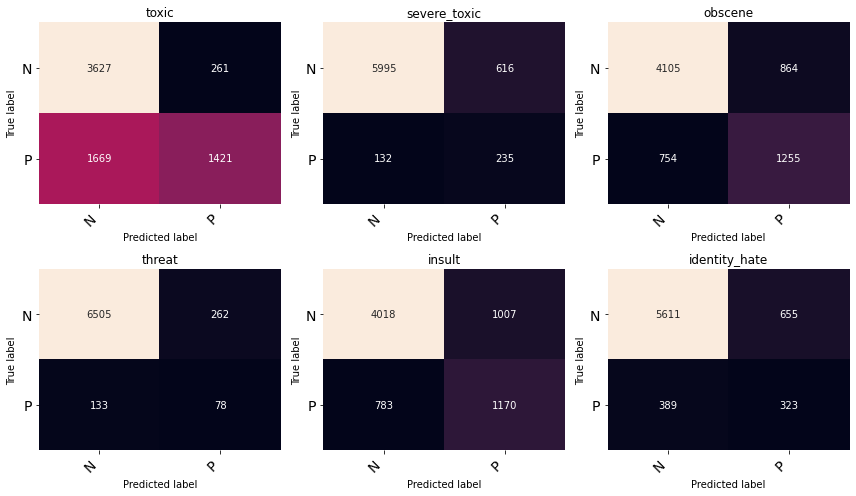

In [39]:
# Predictions
y_pred = spacy_model.predict(spacy_test_x)
y_pred_spacy = (y_pred > 0.5).astype("int32")

# Get confusion matrix
spacy_confusion_matrix = get_confusion_matrix(y_pred_spacy)

# Plot confusion matrix
plot_confusion_matrix(spacy_confusion_matrix, labels)

In [40]:
print(classification_report(y_true, y_pred_spacy, target_names=labels))

               precision    recall  f1-score   support

        toxic       0.84      0.46      0.60      3090
 severe_toxic       0.28      0.64      0.39       367
      obscene       0.59      0.62      0.61      2009
       threat       0.23      0.37      0.28       211
       insult       0.54      0.60      0.57      1953
identity_hate       0.33      0.45      0.38       712

    micro avg       0.55      0.54      0.54      8342
    macro avg       0.47      0.52      0.47      8342
 weighted avg       0.63      0.54      0.56      8342
  samples avg       0.19      0.22      0.19      8342

C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklear

In [41]:
# Get accuracy
acc_dict['spacy'] = get_accuracy(y_pred_spacy)
# Get micro-F1
micro_f1['spacy'] = f1_score(y_true, y_pred_spacy, average='micro')
# Get micro-precision
micro_precision_score['spacy'] = precision_score(y_true, y_pred_spacy, average='micro')

# Get sum of confusion matrices by lemmatization
cm_sum = sum(spacy_confusion_matrix)
cm_list_by_lemma.append(cm_sum.flatten())

At a glance, both lemmatizations produce similar results. The model trained with NLTK Lemmatization performs slightly better in Precision, while spaCy Lemmatization performs slightly better in Recall. 

# Bar Charts of Confusion Matrices by Lemmatization

In [52]:
# Plot a bar graph to show the number of TN, FP, FN, TP for each classifier
# Params:
#   List -      @cm_list_by_lemma:  List of confusion matrices sum by lemmatization
#   List -      @lemma_names:       List of names of lemmatizers
def plot_confusion_matrix_bar_classifier(cm_list_by_lemma, lemma_names):

    # Colour of bars
    colours = ['pink', 'royalblue']
    # Confusion matrix list
    cm_list = np.asarray(cm_list_by_lemma)

    # 4 categories (Confusion matrix squares)
    n = 4
    r = np.arange(n)
    width = 0.3

    #plt.figure(figsize=(15, 5))

    for i in range(len(lemma_names)):

        plt.bar(
            r + width*i, 
            cm_list_by_lemma[i], # Bar data
            align='edge', 
            color=colours[i], 
            edgecolor='black', 
            label=lemma_names[i], 
            width=width
        )

    plt.xlabel("Confusion Matrix Labels")
    plt.ylabel("Number of comments")
    plt.title(f"Confusion Matrix Values of Lemmatizers")
    
    plt.xticks(r + width * len(lemma_names)/2, ['TN','FP','FN','TP'])
    plt.legend()
    
    plt.show()

In [43]:
# Get names of all classifiers
lemma_names = list(micro_f1.keys())

# Create dataframe of accuracies
acc_df = pd.DataFrame.from_dict(acc_dict, orient='index', columns=['accuracy'])

# Create dataframe of micro-average F1-scores
micro_f1_df = pd.DataFrame.from_dict(micro_f1, orient='index', columns=['micro_avg_f1_score'])

# Create dataframe of micro-average precision scores
micro_precision_df = pd.DataFrame.from_dict(micro_precision_score, orient='index', columns=['micro_avg_precision_score'])

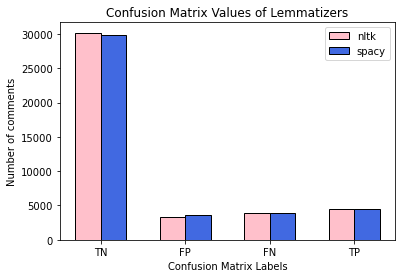

In [53]:
plot_confusion_matrix_bar_classifier(cm_list_by_lemma, lemma_names)

1. The model trained with NLTK Lemmatizer has a higher TN value than spaCy. The difference in FN appears negligible.
2. The model trained with spaCy Lemmatizer has a higher FP value than NLTK. The difference in TP appears negligible.

Since NLTK has a higher TN and lower FP value than spaCy, it appears to be the better lemmatizer.

# Micro-average F1-score, Micro-average Precision score and Accuracy
For further comparison, I will be comparing these 3 metrics to determine the better lemmatizer.

In [47]:
print(micro_f1_df.sort_values(by=['micro_avg_f1_score'], ascending=False))

       micro_avg_f1_score
nltk             0.549212
spacy            0.543635


In [48]:
print(micro_precision_df.sort_values(by=['micro_avg_precision_score'], ascending=False))

       micro_avg_precision_score
nltk                    0.569352
spacy                   0.550141


In [49]:
print(acc_df.sort_values(by=['accuracy'], ascending=False))

       accuracy
nltk   0.826502
spacy  0.820268


# Conclusion - Best Lemmatizer
## NLTK
The difference is slight, but it performed better than spaCy lemmatization in all areas.

# Issues Faced
As mentioned in the beginning of the notebook, I was severely limited by the available lemmatizations to choose from.<br>
Most tutorials I found chose NLTK as their lemmatizer, and after implementing both NLTK and spaCy for lemmatization, it is clear why NLTK is a better choice:
* NLTK lemmatizer is more versatile. It is easy to use with one's own pre-processed tokens.
* spaCy requires the user to integrate their tokens into spaCy's pipeline by converting them into spaCy Doc objects before the user is able to use spaCy lemmatizer.
* spaCy's lemmatizer has a bug which returns the lemmatization of 'first' as the unicode of '1'.
    * It is a known issue: https://github.com/explosion/spaCy/issues/6281
    * Attempts at dynamically working around it were unsuccessful. 
    * Encoding/decoding the unicode did not work as Python would not detect the output as unicode or as starting with '\u'.
    * When I printed the output directly in the for loop, it would return as '1', but when appended into a list, the output of the list printed the unicode value.
    * The only workaround I could do was to replace the lemmatization as a hardcoded 'first'. This is obviously not a good solution as other words could have the same issue but they might not have been spotted.
* However, NLTK has its own drawbacks. 
    * It has a long run time. The long run time made it difficult to test the lemmatization during implementation as each run took 15-20 minutes. I was able to reduce the run time to 4-5 minutes by making use of lru cache. spaCy was significantly faster at processing lemmatization.
    * Its need to use WordNet pos tags despite NLTK having pos tags internally. There was a need to adjust the implementation due to having to map WordNet pos tags to words for lemmatization.